# Predict protein structure using ColabFold running on Jupyterlab notebook

### The notebook has been adapted from: https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb

In [1]:
import tensorflow as tf
gpu = tf.config.list_physical_devices('GPU')
gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.7.0')

## Specify protein sequence and ColabFold parameters

In [1]:
import os.path
import re
import hashlib
import random


def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK'

# SARS-CoV-2 spike protein sequence
#query_sequence = "MFGFFVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSKPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCT"
#query_sequence = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNYPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGNTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPSTVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPINFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDISARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQQLGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT"

# remove whitespaces
query_sequence = "".join(query_sequence.split())
results_dir = "colab_results/"
jobname = 'test'

if not os.path.isdir(results_dir):
    os.mkdir(results_dir)

# remove whitespaces
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)
while os.path.isfile(f"{results_dir}{jobname}.csv"):
  jobname = add_hash(basejobname, ''.join(random.sample(query_sequence,len(query_sequence))))

# create a tabular file with the query sequence
with open(f"{results_dir}{jobname}.csv", "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

queries_path = f"{results_dir}{jobname}.csv"

## Amber refinement
use_amber = False # {type:"boolean"}
#Options for template_mode - "none" = no template information is used and "pdb70" = detect templates in pdb70
template_mode = "pdb70" # ["none", "pdb70"]

if template_mode == "pdb70":
  use_templates = True
else:
  use_templates = False


### MSA options (custom MSA upload, single sequence, pairing mode)
#Options for msa_mode ["MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)","single_sequence"]
msa_mode = "MMseqs2 (UniRef only)" #"MMseqs2 (UniRef+Environmental)"
#Options for pair_mode - "unpaired+paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.
pair_mode = "unpaired+paired" # ["unpaired+paired","paired","unpaired"] {type:"string"}

# decide which a3m to use
if msa_mode.startswith("MMseqs2"):
  a3m_file = f"{results_dir}{jobname}.a3m"
else:
  a3m_file = f"{results_dir}{jobname}.single_sequence.a3m"
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)


### Advanced settings
#Options for model_type: "auto" = protein structure prediction using "AlphaFold2-ptm" and complex prediction "AlphaFold-multimer-v2". For complexes "AlphaFold-multimer-v[1,2]" and "AlphaFold-ptm" can be used.
model_type = "auto" # ["auto", "AlphaFold2-ptm", "AlphaFold2-multimer-v1", "AlphaFold2-multimer-v2"]
num_recycles = 3 # [1,3,6,12,24,48]

## Download AlphaFold2 weights and run prediction

2022-03-25 09:46:07,671 Running colabfold 1.2.0 (48d1771ccfcf3580f8e4d03df7af44163241834f)
2022-03-25 09:46:07,698 Found 6 citations for tools or databases
2022-03-25 09:46:16,543 Query 1/1: test_39f29 (length 59)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:02 remaining: 00:00]


2022-03-25 09:46:30,517 Sequence 0 found templates: [b'2op8_A' b'2opa_A' b'6bgn_J' b'4faz_C' b'6ogm_D' b'6ogm_J' b'3ry0_A'
 b'3ry0_B' b'2x4k_A' b'4fdx_A' b'4fdx_B' b'3ej3_B' b'3ej3_L' b'3ej9_D'
 b'3mb2_A' b'2orm_A' b'2orm_C' b'3m21_C' b'3m20_A' b'3m20_C']
2022-03-25 09:46:30,746 Running model_1


2022-03-25 09:50:41.596210: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_apply_fn.5
********************************


2022-03-25 09:52:14,476 model_1 took 333.8s (3 recycles) with pLDDT 97.8


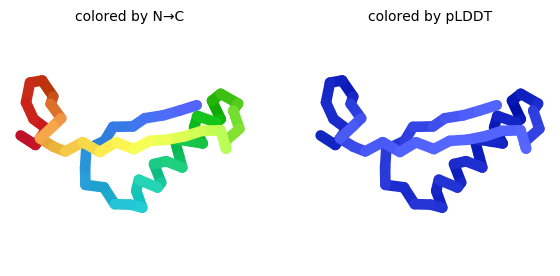

2022-03-25 09:52:23,576 reranking models by plddt
2022-03-25 09:52:24,288 Done


In [2]:
# Run Prediction

import sys
import colabfold
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run
from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt


def prediction_callback(unrelaxed_protein, length, prediction_result, input_features):
  fig = plot_protein(unrelaxed_protein, Ls=length, dpi=100)
  plt.show()
  plt.close()

result_dir = "colab_results/"

# logging
setup_logging(Path(results_dir).joinpath("log.txt"))

queries, is_complex = get_queries(queries_path)

path_dir = Path(results_dir)

# download AlphaFold2 weights
download_alphafold_params(model_type, path_dir)

# execute prediction
run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    use_amber=use_amber,
    msa_mode=msa_mode,
    num_models=1,
    num_recycles=num_recycles,
    model_order=[1, 2, 3, 4, 5],
    is_complex=is_complex,
    data_dir=path_dir,
    keep_existing_results=False,
    recompile_padding=1.0,
    pair_mode=pair_mode,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
)

## Display 3D structure

In [3]:
import py3Dmol
import glob
import matplotlib.pyplot as plt

# set different plotting parameters
rank_num = 1 # ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" # ["chain", "lDDT", "rainbow"]
show_sidechains = True
show_mainchains = True

jobname_prefix = ".custom" if msa_mode == "custom" else ""

if use_amber:
  pdb_filename = f"{results_dir}{jobname}{jobname_prefix}_relaxed_rank_{rank_num}_model_*.pdb"
else:
  pdb_filename = f"{results_dir}{jobname}{jobname_prefix}_unrelaxed_rank_{rank_num}_model_*.pdb"

pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view


show_pdb(rank_num,show_sidechains, show_mainchains, color).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Plots


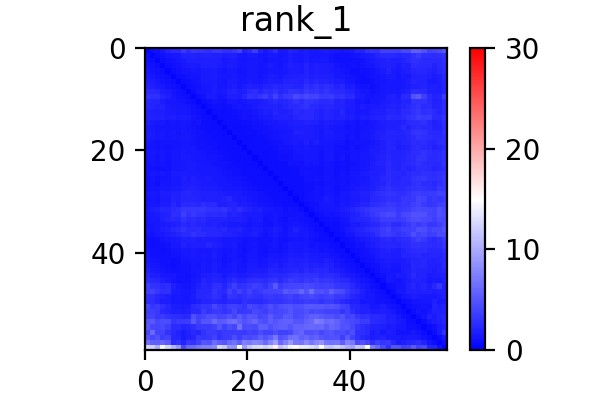
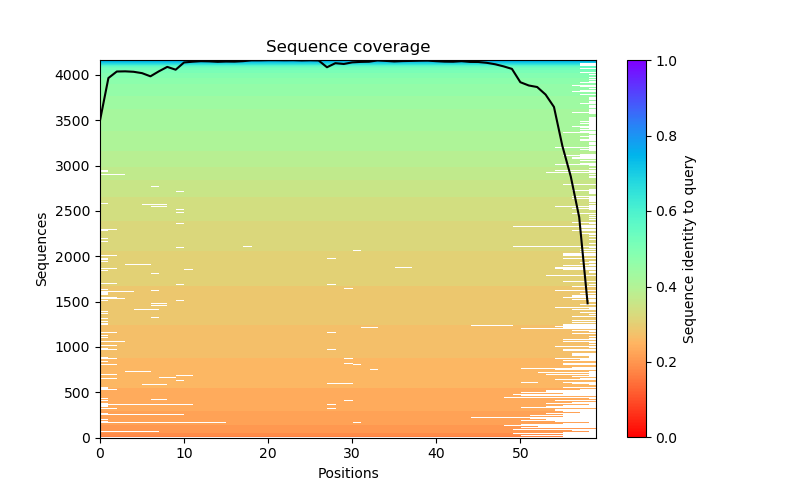
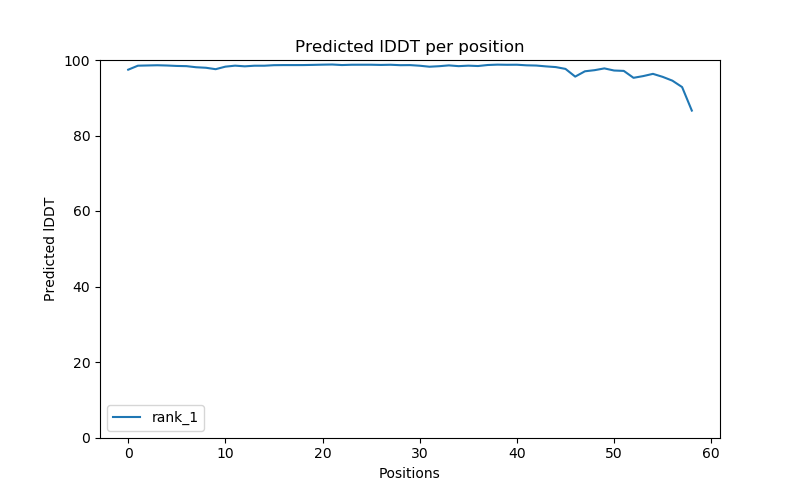

In [4]:
#Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(f"{results_dir}{jobname}{jobname_prefix}_PAE.png")
cov = image_to_data_url(f"{results_dir}{jobname}{jobname_prefix}_coverage.png")
plddt = image_to_data_url(f"{results_dir}{jobname}{jobname_prefix}_plddt.png")
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))


In [ ]:
# Release GPU memory
from numba import cuda 
cuda.select_device(0)
cuda.close()